In [1]:
import time
from textwrap import wrap

In [2]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import Input
from tensorflow.keras.layers import (
GRU,
Add,
AdditiveAttention,
Attention,
Concatenate,
Dense,
Embedding,
LayerNormalization,
Reshape,
StringLookup,
TextVectorization,
)

In [3]:
print(tf.version.VERSION)


2.17.0


In [4]:
# Change these to control the accuracy/speed
VOCAB_SIZE = 20000  # use fewer words to speed up convergence
ATTENTION_DIM = 512  # size of dense layer in Attention
WORD_EMBEDDING_DIM = 128
# InceptionResNetV2 takes (299, 299, 3) image as inputs
# and return features in (8, 8, 1536) shape
FEATURE_EXTRACTOR = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
include_top=False, weights="imagenet")
IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3
FEATURES_SHAPE = (8, 8, 1536)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [5]:
GCS_DIR = "gs://asl-public/data/tensorflow_datasets/"
BUFFER_SIZE = 1000

In [6]:
def get_image_label(example):
  caption = example["captions"]["text"][0]  # only the first caption per image
  img = example["image"]
  img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
  img = img / 255
  return {"image_tensor": img, "caption": caption}
trainds = tfds.load("coco_captions", split="train", data_dir=GCS_DIR)
trainds = trainds.map(
get_image_label, num_parallel_calls=tf.data.AUTOTUNE
).shuffle(BUFFER_SIZE)
trainds = trainds.prefetch(buffer_size=tf.data.AUTOTUNE)

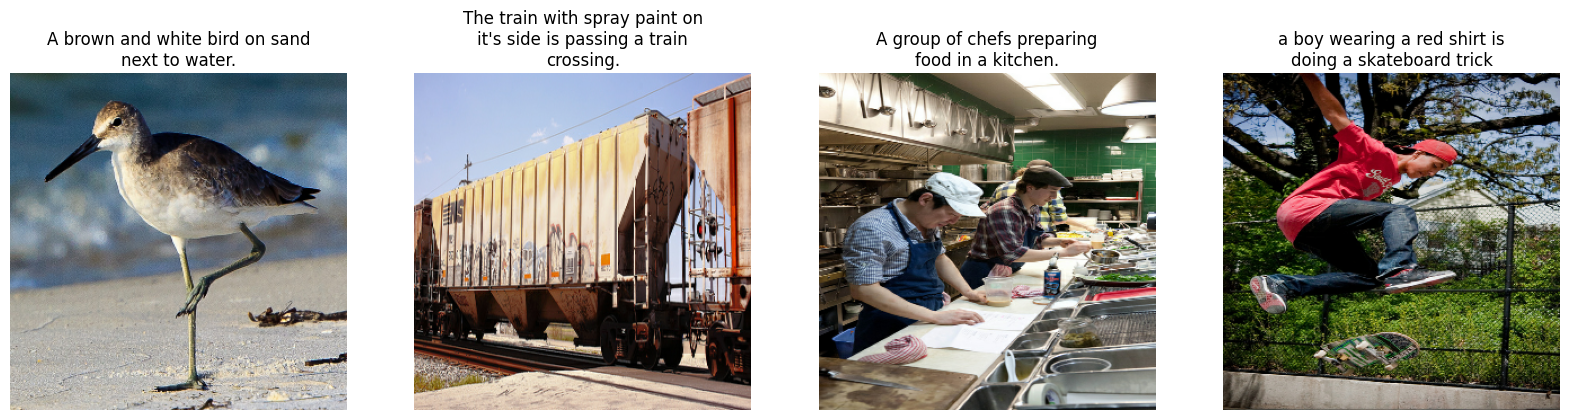

In [7]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
for idx, data in enumerate(trainds.take(4)):
  ax[idx].imshow(data["image_tensor"].numpy())
  caption = "\n".join(wrap(data["caption"].numpy().decode("utf-8"), 30))
  ax[idx].set_title(caption)
  ax[idx].axis("off")

In [8]:
def add_start_end_token(data):
  start = tf.convert_to_tensor("<start>")
  end = tf.convert_to_tensor("<end>")
  data["caption"] = tf.strings.join([start, data["caption"], end], separator=" " )
  return data
  trainds = trainds.map(add_start_end_token)

In [9]:
MAX_CAPTION_LEN = 64
# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", "")
# Choose the most frequent words from the vocabulary & remove punctuation etc.
tokenizer = TextVectorization(max_tokens=VOCAB_SIZE, standardize=standardize,output_sequence_length=MAX_CAPTION_LEN,)
tokenizer.adapt(trainds.map(lambda x: x["caption"]))

KeyboardInterrupt: 

In [ ]:
tokenizer(["<start> This is a sentence <end>"])


In [ ]:
sample_captions = []
for d in trainds.take(5):
  sample_captions.append(d["caption"].numpy())

In [ ]:
sample_captions

In [ ]:
print(tokenizer(sample_captions))


In [ ]:
for wordid in tokenizer([sample_captions[0]])[0]:
    print(tokenizer.get_vocabulary()[wordid], end=" ")

In [ ]:
# Lookup table: Word -> Index
word_to_index = StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary())
# Lookup table: Index -> Word
index_to_word = StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True)

In [ ]:
BATCH_SIZE = 32
def create_ds_fn(data):
  img_tensor = data["image_tensor"]
  caption = tokenizer(data["caption"])
  target = tf.roll(caption, -1, 0)
  zeros = tf.zeros([1], dtype=tf.int64)
  target = tf.concat((target[:-1], zeros), axis=-1)
  return (img_tensor, caption), target

In [ ]:
batched_ds = (trainds.map(create_ds_fn).batch(BATCH_SIZE, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE))

In [ ]:
for (img, caption), label in batched_ds.take(2):
  print(f"Image shape: {img.shape}")
  print(f"Caption shape: {caption.shape}")
  print(f"Label shape: {label.shape}")
  print(caption[0])
  print(label[0])

In [ ]:
FEATURE_EXTRACTOR.trainable = False
image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
image_features = FEATURE_EXTRACTOR(image_input)
x = Reshape((FEATURES_SHAPE[0] * FEATURES_SHAPE[1], FEATURES_SHAPE[2]))(image_features)
encoder_output = Dense(ATTENTION_DIM, activation="relu")(x)
encoder = tf.keras.Model(inputs=image_input, outputs=encoder_output)
encoder.summary()


In [ ]:
word_input = Input(shape=(MAX_CAPTION_LEN), name="words")
embed_x = Embedding(VOCAB_SIZE, ATTENTION_DIM)(word_input)
decoder_gru = GRU(ATTENTION_DIM,return_sequences=True,return_state=True,)
gru_output, gru_state = decoder_gru(embed_x)
decoder_attention = Attention()
context_vector = decoder_attention([gru_output, encoder_output])
addition = Add()([gru_output, context_vector])
layer_norm = LayerNormalization(axis=-1)
layer_norm_out = layer_norm(addition)
decoder_output_dense = Dense(VOCAB_SIZE)
decoder_output = decoder_output_dense(layer_norm_out)

In [ ]:
decoder = tf.keras.Model(inputs=[word_input, encoder_output], outputs=decoder_output)
tf.keras.utils.plot_model(decoder)

In [ ]:
decoder.summary()

In [ ]:
image_caption_train_model = tf.keras.Model(inputs=[image_input, word_input], outputs=decoder_output)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="none")

In [ ]:
def loss_function(real, pred):
  loss_ = loss_object(real, pred)
# returns 1 to word index and 0 to padding (e.g. [1,1,1,1,1,0,0,0,0,...,0])
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  mask = tf.cast(mask, dtype=tf.int32)
  sentence_len = tf.reduce_sum(mask)
  loss_ = loss_[:sentence_len]
  return tf.reduce_mean(loss_, 1)
image_caption_train_model.compile(
    optimizer="adam",
    loss=loss_function,
)

In [ ]:
history = image_caption_train_model.fit(batched_ds, epochs=1)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model_path = "/content/drive/MyDrive/model.h5"
image_caption_train_model.save(model_path)

In [ ]:
gru_state_input = Input(shape=(ATTENTION_DIM), name="gru_state_input")

# Reuse trained GRU, but update it so that it can receive states.
gru_output, gru_state = decoder_gru(embed_x, initial_state=gru_state_input)

# Reuse other layers as well
context_vector = decoder_attention([gru_output, encoder_output])
addition_output = Add()([gru_output, context_vector])
layer_norm_output = layer_norm(addition_output)
decoder_output = decoder_output_dense(layer_norm_output)
# Define prediction Model with state input and output
decoder_pred_model = tf.keras.Model(inputs=[word_input, gru_state_input, encoder_output],outputs=[decoder_output, gru_state],)

In [ ]:
MINIMUM_SENTENCE_LENGTH = 5


In [ ]:
## Probabilistic prediction using the trained model
def predict_caption(filename):
  gru_state = tf.zeros((1, ATTENTION_DIM))
  img = tf.image.decode_jpeg(tf.io.read_file(filename),channels=IMG_CHANNELS)
  img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
  img = img / 255
  features = encoder(tf.expand_dims(img, axis=0))
  dec_input = tf.expand_dims([word_to_index("<start>")], 1)
  result = []
  for i in range(MAX_CAPTION_LEN):
    predictions, gru_state = decoder_pred_model([dec_input, gru_state, features])
# draws from log distribution given by predictions
    top_probs, top_idxs = tf.math.top_k(input=predictions[0][0], k=10, sorted=False)
    chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
    predicted_id = top_idxs.numpy()[chosen_id][0]
    result.append(tokenizer.get_vocabulary()[predicted_id])
    if predicted_id == word_to_index("<end>"):
      return img, result
    dec_input = tf.expand_dims([predicted_id], 1)
  return img, result

In [ ]:
filename = "/content/wallpaper.jpg"


In [ ]:
for i in range(5):
  image, caption = predict_caption(filename)
  print(" ".join(caption[:-1]) + ".")
img = tf.image.decode_jpeg(tf.io.read_file(filename),channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");